# Lens modeling with lenstronomy

Author: Nishuti \
Acknowledgement: Nahid.

In [ ]:
# import of standard python libraries
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline
!pip install corner
!pip install lenstronomy

### Load imaging data

In [ ]:
with h5py.File(r"DESIJ0618+5018_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

image_data = kwargs_data["image_data"]

In [ ]:
with h5py.File(r"psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf

psf_map = kwargs_psf["kernel_point_source"]

### Visualizing the data

In [ ]:
image_data = kwargs_data["image_data"]
psf_map = kwargs_psf["kernel_point_source"]

In [ ]:
kwargs_psf = {
    "psf_type": "PIXEL",
    "kernel_point_source": psf_map,
}

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_9757/1365966619.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');


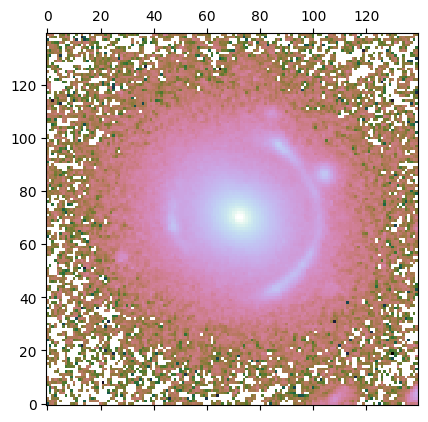

In [ ]:
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");

### likelihood mask using lenstronomy functions

[[ 5.64  5.56  5.48 ... -5.32 -5.4  -5.48]
 [ 5.64  5.56  5.48 ... -5.32 -5.4  -5.48]
 [ 5.64  5.56  5.48 ... -5.32 -5.4  -5.48]
 ...
 [ 5.64  5.56  5.48 ... -5.32 -5.4  -5.48]
 [ 5.64  5.56  5.48 ... -5.32 -5.4  -5.48]
 [ 5.64  5.56  5.48 ... -5.32 -5.4  -5.48]] [[-5.64 -5.64 -5.64 ... -5.64 -5.64 -5.64]
 [-5.56 -5.56 -5.56 ... -5.56 -5.56 -5.56]
 [-5.48 -5.48 -5.48 ... -5.48 -5.48 -5.48]
 ...
 [ 5.32  5.32  5.32 ...  5.32  5.32  5.32]
 [ 5.4   5.4   5.4  ...  5.4   5.4   5.4 ]
 [ 5.48  5.48  5.48 ...  5.48  5.48  5.48]]


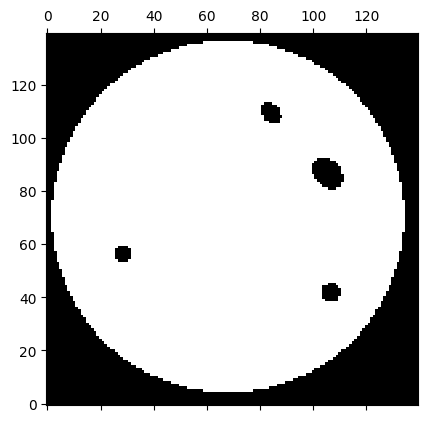

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_9757/1808631925.py:75: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data),
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_9757/1808631925.py:75: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data),


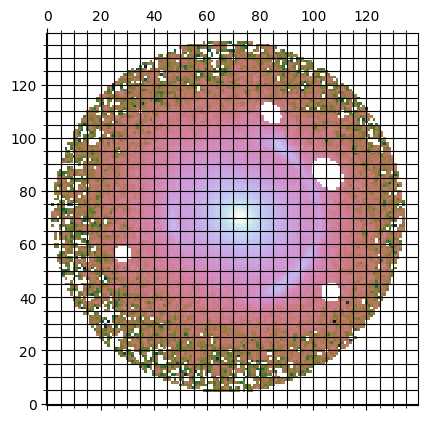

In [ ]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

print(x_coords, y_coords)

r = 5.3  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra + 0.2,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


# For the galaxy at 2 o clock

mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.8,
    lens_center_dec + 1.3,
    0.40,
    0.53,
    -7,
)

# For the galaxy at 8 o clock

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 3.37,
    lens_center_dec - 1.1,
    0.26,
    0.26,
    0,
)

# For the galaxy at 1 o clock

mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.1,
    lens_center_dec + 3.1,
    0.26,
    0.36,
    -7,
)

# For the galaxy at 4 o clock

mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec - 2.3,
    0.29,
    0.29,
    0,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)


mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# mask image data
masked_image_data = np.multiply(image_data, mask)

plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

### Compiling the lens model

In [ ]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

### Mass model of the lens galaxy

In [ ]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# setting EPL parameters
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 2.1247,
        "gamma": 2.4541,
        "e1": -0.4998,
        "e2": -0.0664,
        "center_x": -0.4962,
        "center_y": 0.6321,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2.0,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

# Setting SHEAR Parameters
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": -0.0647, "gamma2": -0.0249, "ra_0": 0, "dec_0": 0})
kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1, "ra_0": 0, "dec_0": 0})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -100, "dec_0": -100})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 100, "dec_0": 100})

## Source Galaxy's Light Model

In [ ]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# setting SERSIC_ELLIPSE parameters
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 9.98409,
        "n_sersic": 1.0,
        "e1": 0.4281,
        "e2": 0.4860,
        "center_x": -0.1262,
        "center_y": -0.1128,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# setting SHAPELETS parameters
fixed_source.append({"n_max": 5})
kwargs_source_init.append({"beta": 0.15, "center_x": -0.1262, "center_y": -0.1128})
kwargs_source_sigma.append({"beta": 0.01, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.001, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.2, "center_x": 10, "center_y": 10})

## Lens Galaxy's Light Model

In [ ]:
# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


# 1st sersic

fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.1473,
        "n_sersic": 1.0,
        "e1": -0.0235,
        "e2": 0.07099,
        "center_x": -0.1672,
        "center_y": -0.01705,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# 2nd sersic

fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 1.3331,
        "n_sersic": 4.0,
        "e1": 0.0549,
        "e2": 0.0933,
        "center_x": -0.1672,
        "center_y": -0.01705,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### Merging source and lens models

In [ ]:
# joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]

joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_source_with_source": joint_shapelets_with_sersic,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
}

### Quantitative configurations

In [ ]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

### Compiling all the information that needs to be transmitted to Lenstronomy

In [ ]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

 ### Model fiting

In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0296181517644651 reduced X^2 of best position
-6958.1594696242555 log likelihood
13516 effective number of data points
[{'theta_E': 2.4104801001721823, 'gamma': 2.1260212569731882, 'e1': -0.4656449682137436, 'e2': -0.019176752212779917, 'center_x': -0.5334411538173431, 'center_y': 0.10796468161481466}, {'gamma1': -0.1902569031382407, 'gamma2': 0.007605684224462351, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 9.950312511155948, 'n_sersic': 1.0, 'e1': 0.49951746325482116, 'e2': 0.464205353078512, 'center_x': -0.3731372942985322, 'center_y': 0.06821978472225106}, {'amp': 1, 'n_max': 5, 'beta': 0.09286872986639635, 'center_x': -0.3731372942985322, 'center_y': 0.06821978472225106}] source result
[{'amp': 1, 'R_sersic': 0.1496841887388361, 'n_sersic': 1.0, 'e1': 0.030850410343685356, 'e2': 0.07103373386310463, 'center_x': -0.1669527884771535, 'center_y': -0.017062552076361037}, {'amp': 1,

In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ0618+5018_pso_output_V_7(5).joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

In [ ]:
### load saved best fit parameters ###

load_output_path = "DESIJ0618+5018_pso_output_V_7(5).joblib"
with open(load_output_path, "rb") as f:
    [input_, output_] = joblib.load(f)

(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

### Illustrating the fitted model

-1.02612586191185 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0261258619118478


/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_9757/2886396031.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


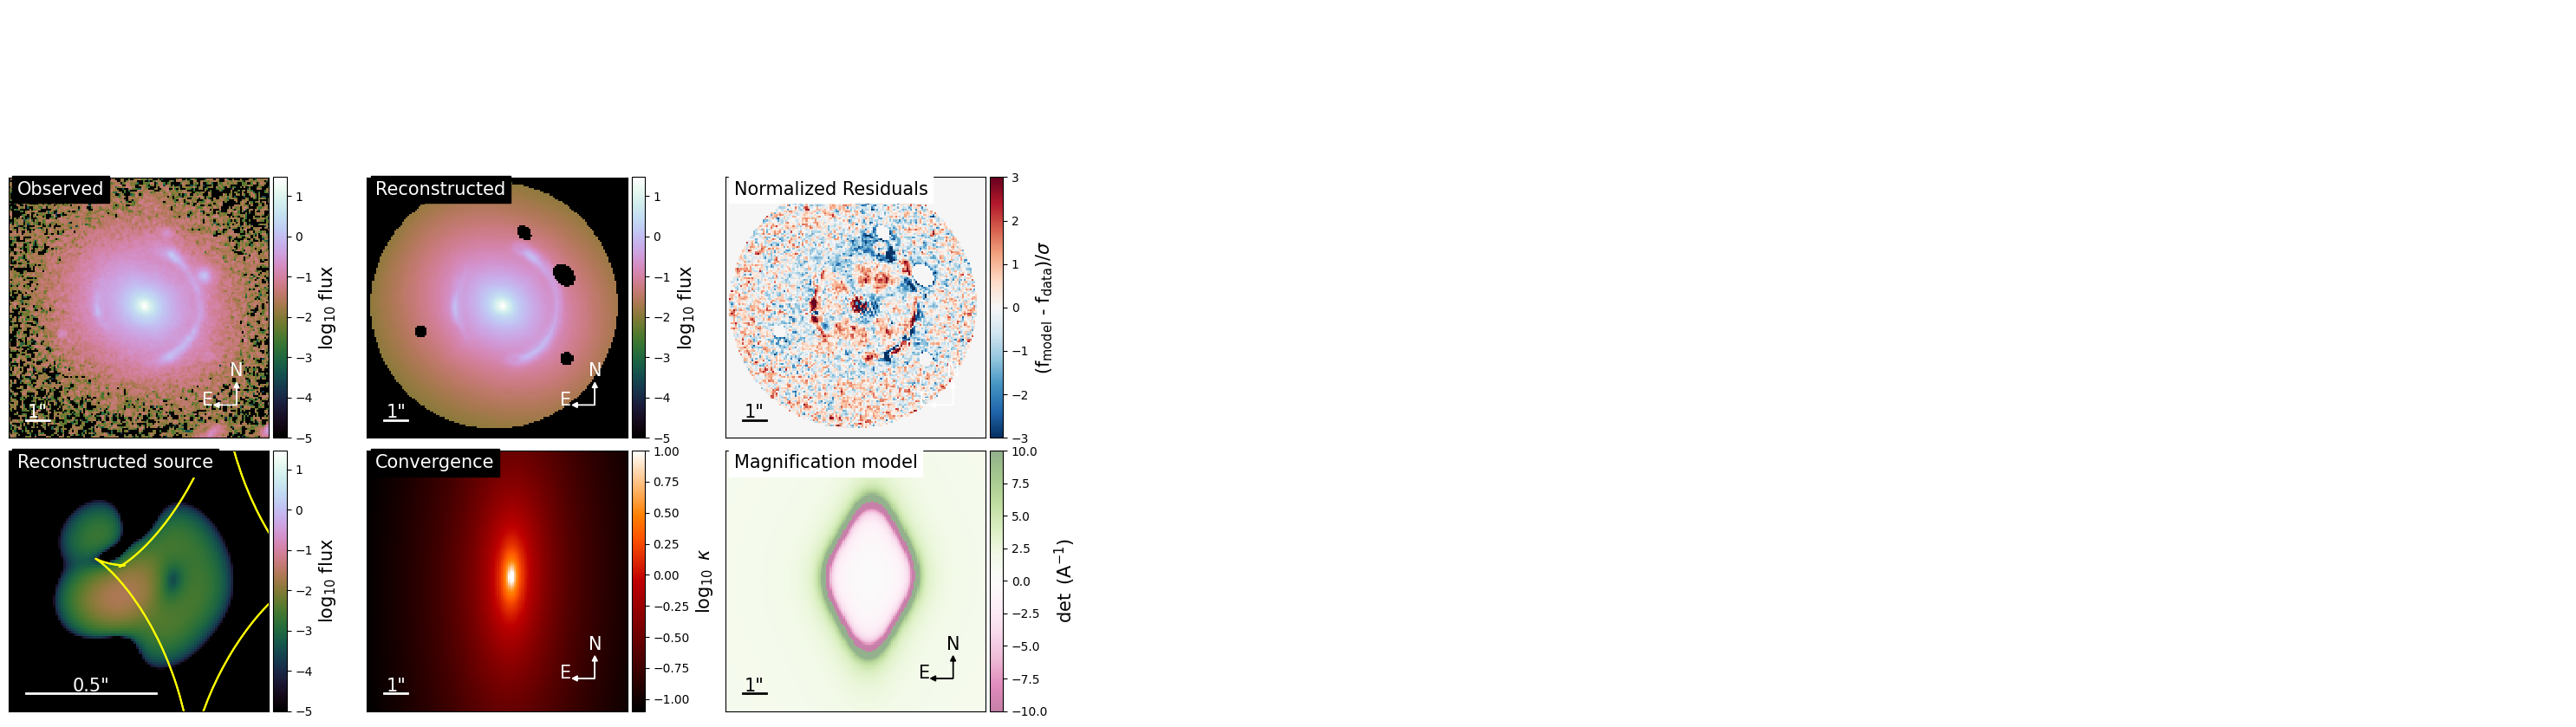

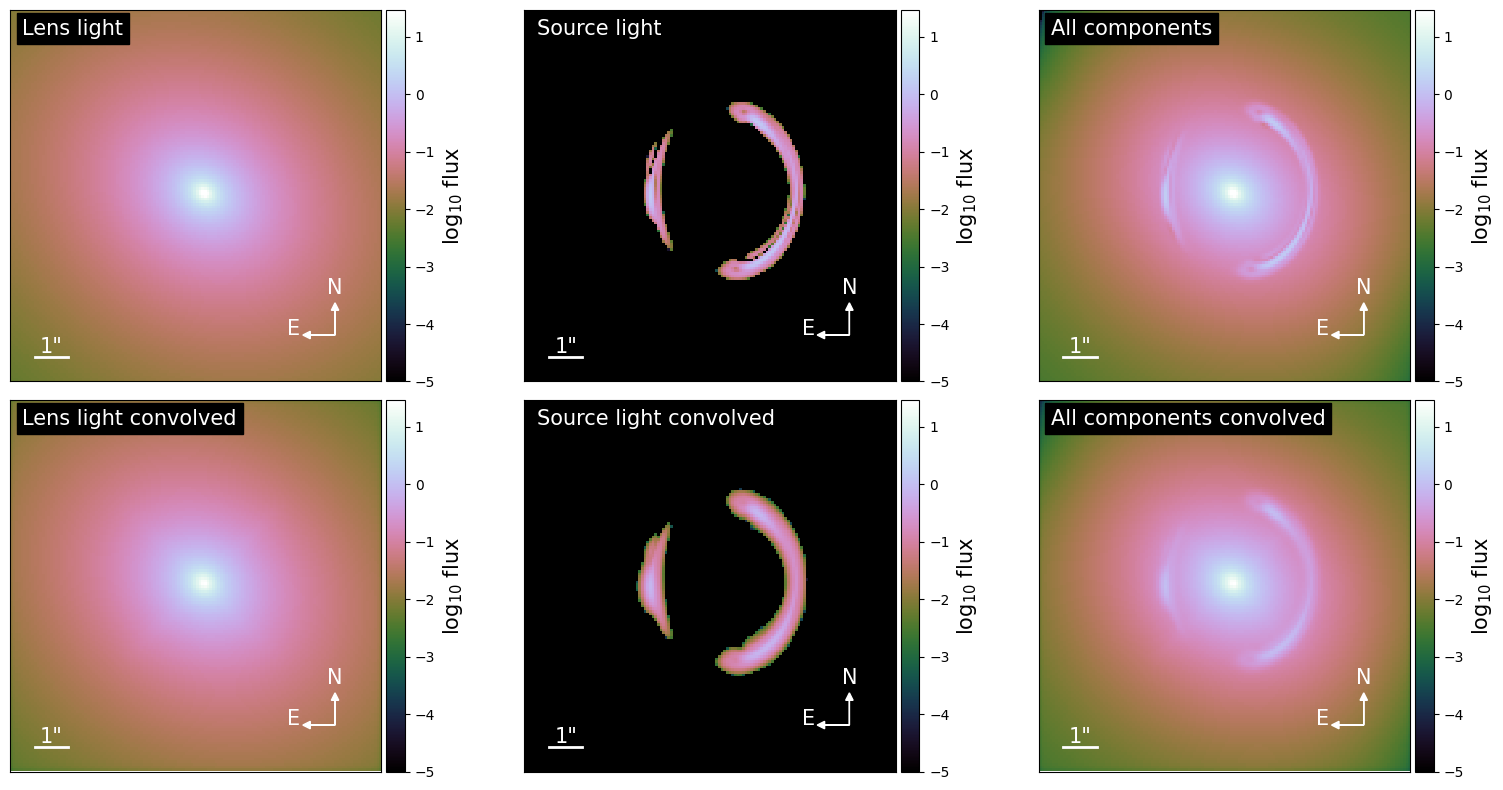

{'kwargs_lens': [{'theta_E': 2.4104801001721823, 'gamma': 2.1260212569731882, 'e1': -0.4656449682137436, 'e2': -0.019176752212779917, 'center_x': -0.5334411538173431, 'center_y': 0.10796468161481466}, {'gamma1': -0.1902569031382407, 'gamma2': 0.007605684224462351, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': -0.5549763119722808, 'R_sersic': 9.950312511155948, 'n_sersic': 1.0, 'e1': 0.49951746325482116, 'e2': 0.464205353078512, 'center_x': -0.3731372942985322, 'center_y': 0.06821978472225106}, {'amp': array([ 275.87762703,  106.92337197, -120.81286295,   50.59134857,
        -94.29103924,   16.15998462,  -16.68049146,  -37.56305924,
        -21.12752767,   27.17064046,   36.61757785,    5.7373362 ,
         47.06762463,   48.76155037,   -4.40044771,  -12.64450827,
          5.84515516,    6.52085378,   24.64071481,  -13.11656175,
         -6.27599456]), 'n_max': 5, 'beta': 0.09286872986639635, 'center_x': -0.3731372942985322, 'center_y': 0.06821978472225106}], 'kwargs_lens_light':

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")

model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, with_caustics=True, scale_size=0.5, numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)